In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from scipy import signal
from scipy.fft import fft, ifft
import soundfile as sf

In [2]:
def specgram(x, fftSize, hopSize, sr):
    hanWin = np.hanning(fftSize)
    numFfts = math.floor(len(x) / hopSize)
    specInput = np.zeros(fftSize)
    halfFftSize = int(fftSize/2)
    
    XMag = np.zeros((numFfts, halfFftSize), dtype=np.float64)
    for i in range(numFfts):
        start = int(i * hopSize)
        for j in range(fftSize):
            pos = start + j
            if pos < len(x):
                specInput[j] = x[pos]
            else:
                specInput[j] = 0
        specInput = np.multiply(specInput, hanWin)
        fftRes = fft(specInput)[:halfFftSize]
        XMag[i] = np.absolute(fftRes)
    XMag = XMag / np.max(XMag)
    freqVector = np.linspace(0, int(sr / 2), int(fftSize / 2))
    timeVector = np.linspace(0, len(x) / sr, len(x))
    return (freqVector, timeVector, XMag)

def plotSpecgram(freq_vector, time_vector, magnitude_spectrogram, axis):
    if len(freq_vector) < 2 or len(time_vector) < 2:
        return

    Z = 20. * np.log10(magnitude_spectrogram)
    Z = np.flipud(Z)
    Z =np.rot90(Z)
    Z = np.fliplr(Z)

  
    pad_xextent = (time_vector[1] - time_vector[0]) / 2
    xmin = np.min(time_vector) - pad_xextent
    xmax = np.max(time_vector) + pad_xextent
    extent = xmin, xmax, freq_vector[0], freq_vector[-1]
  
    im = axis.imshow(Z, None, extent=extent, 
                           origin='upper')
    axis.axis('auto')

def makeSquareWave(sqFreq, time, amp, inSr):
    numSamples = int(time * inSr)
    deltaPhi = float(sqFreq) / float(inSr)
    phi = 0
    
    tBuf = np.zeros(numSamples)
    buffer = np.zeros(numSamples)
    for i in range(numSamples):
        if phi < 0.5:
            buffer[i] = amp
        else:
            buffer[i] = amp * -1
        tBuf[i] = float(i) / float(inSr)
        phi += deltaPhi
        while phi >= 1:
            phi -= 1
    return (tBuf, buffer)

def makeSquareWaveAdditive(sqFreq, numHarmonics, time, amp, inSr):
    numSamples = int(time * inSr)
    sqLength = int(float(inSr) / float(sqFreq))
    amp = amp * 4 / math.pi
    
    phis = np.zeros(numHarmonics)
    phiDeltas = np.zeros(numHarmonics)
    for i in range(numHarmonics):
        harmonicFreq = float(sqFreq) * (float(i) * 2 + 1)
        phiDeltas[i] = harmonicFreq / float(inSr)

    tBuf = np.zeros(numSamples)
    buffer = np.zeros(numSamples)
    for i in range(numSamples):
        tBuf[i] = float(i) / float(inSr)
        for j in range(numHarmonics):
            buffer[i] += math.sin(2 * math.pi * phis[j]) * amp / (float(j) * 2 + 1)
            phis[j] += phiDeltas[j]
            while phis[j] >= 1:
                phis[j] -= 1
        
    return (tBuf, buffer)

def plotTimeAndSpec(timeTuple, specTuple):
    fig, axs = plt.subplots(2)

    axs[0].plot(timeTuple[0][:100], timeTuple[1][:100])
    plotSpecgram(*specTuple, axs[1])

    fig.set_figwidth(10)
    fig.set_figheight(10)
    axs[1].set_xlabel("Time (s)")

    axs[0].set_ylabel("Amplitude")
    axs[1].set_ylabel("Frequency")

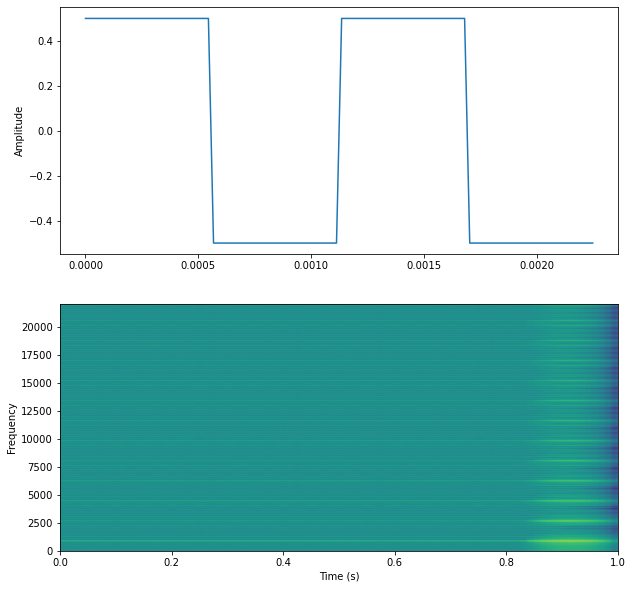

In [3]:
sr = 44100

naiveSquare = makeSquareWave(890, 1, 0.5, sr)
sf.write('output/naiveSquare.wav', naiveSquare[1], sr)

naiveSpec = specgram(naiveSquare[1], 8192, 512, sr)

plotTimeAndSpec(naiveSquare, naiveSpec)

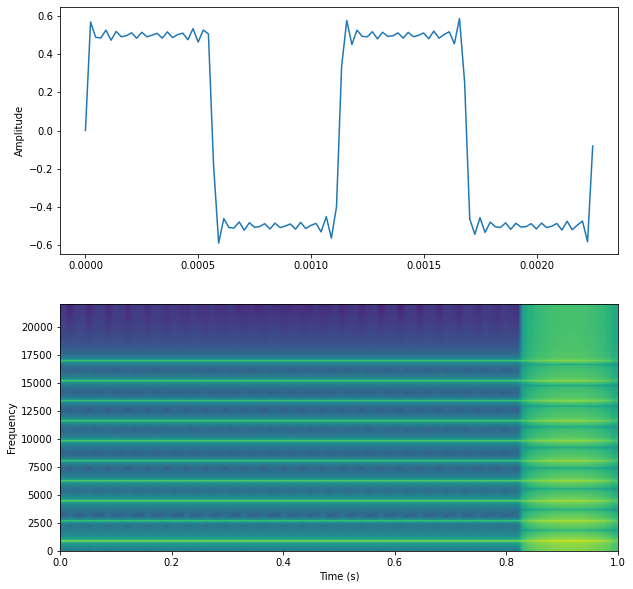

In [4]:
sr = 44100

additiveSquare = makeSquareWaveAdditive(890, 10, 1, 0.5, sr)
sf.write('output/additiveSquare.wav', additiveSquare[1], sr)

additiveSpec = specgram(additiveSquare[1], 8192, 512, sr)

plotTimeAndSpec(additiveSquare, additiveSpec)

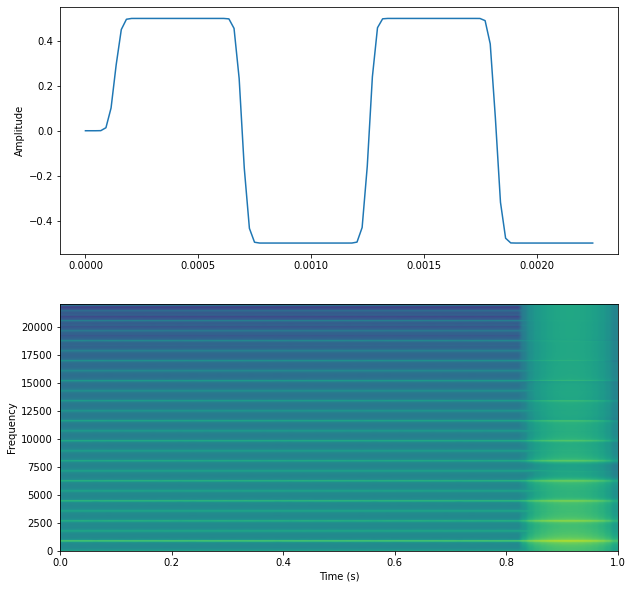

In [5]:
sr = 44100
L = 20

sos = signal.bessel(20, ((sr/2) - 4000), btype='lowpass', output='sos', fs=sr * L)

upsampledSquare = makeSquareWave(890, 1, 0.5, sr * L)
upsampledFilteredSquare = signal.sosfilt(sos, upsampledSquare[1])
oversampledLength = int(len(upsampledFilteredSquare) / L)
oversampledSquareSamples = np.zeros(oversampledLength)
for i in range(oversampledLength):
    oversampledSquareSamples[i] = upsampledFilteredSquare[i * L]
sf.write('output/oversampledSquare.wav', oversampledSquareSamples, sr)

oversampledSpec = specgram(oversampledSquareSamples, 8192, 512, sr)

oversampledSquare = (np.linspace(0, oversampledLength / sr, oversampledLength),
                     oversampledSquareSamples)

plotTimeAndSpec(oversampledSquare, oversampledSpec)

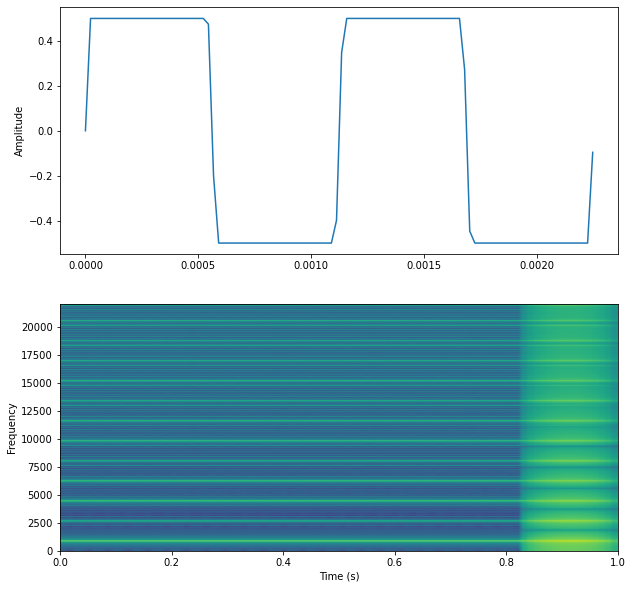

In [6]:
def makePolyBlep(sqFreq, phiOffset, time, amp, inSr):
    numSamples = int(time * inSr)
    deltaPhi = float(sqFreq) / float(inSr)
    blepSize = deltaPhi * 1
    phi = phiOffset
    
    tBuf = np.zeros(numSamples)
    buffer = np.zeros(numSamples)
    for i in range(numSamples):
        if phi < (blepSize):
            v = phi / blepSize
            buffer[i] = ((v+v) - (v*v) - 1.0) * amp
        elif phi > (1 - blepSize):
            v = (phi - 1.0) / blepSize
            buffer[i] = ((v*v) + (v+v) + 1.0) * amp
        else:
            buffer[i] = 0
        tBuf[i] = float(i) / float(inSr)
        phi += deltaPhi
        while phi >= 1:
            phi -= 1
    return (tBuf, buffer)

startBlep = makePolyBlep(890, 0, 1, 0.5, sr)
midBlep = makePolyBlep(890, 0.5, 1, 0.5, sr)

blepT, blepSquareSamples = makeSquareWave(890, 1, 0.5, sr)
blepSquareSamples += startBlep[1] - midBlep[1]
sf.write('output/polyBlepSquare.wav', blepSquareSamples, sr)


blepSpec = specgram(blepSquareSamples, 8192, 512, sr)

plotTimeAndSpec((blepT, blepSquareSamples), blepSpec)
